v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

v6. Setting values that had been 0 to some very small number to avoid sending params to inf or -inf. For a 4x4 grid there are a few cells which would contain more than one ROI. Rather than overwriting the previous one we combine the two into one larger ROI.

v7. Going to 2x2 grid. There are a max of 4 ROIs per image, if we combine ones that occur in the same cell this may work better.

v8. Trying a 3x3 grid instead.

v9. If the center of an ROI is within 5% of the border putting it in both cells instead of picking one.

v10. Changing how ROIs are assigned to cells:
* Always assign the ROI to the cell that contains it's center
* If the center is near a border or a corner assign it to the neighboring cells
* If the ROI is large and overlaps multiple cells, we will also assign smaller ROIs to those cells.

v11. Making confidence for jittered ROIs equal to the overlap with the main ROI instead of 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [2]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [3]:
# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

In [4]:
GRID_SIZE = 7
CELL_WIDTH = 1024 // GRID_SIZE
CELL_SIZE_NORM = CELL_WIDTH / 1024

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

num_dups = 0

# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []
iffy_images = []
roi_sizes = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [0, 0.5, 0.5, 0.001, 0.001]
                    
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x / (1024 / GRID_SIZE))
            y_pixel = int(center_y / (1024 / GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            # special cases
            if GRID_SIZE == 5 and filename in ["085a6486-c3b3-4ca2-80f1-be07d23e853b", "0afeabf5-d5a3-454f-a50d-887f0d21106c", "1d57c801-71b4-49da-8933-2cabdc927fef", "49c04987-96af-4edb-b560-53c56a357cac"]:
                print("Special Case:", filename, x_pixel, y_pixel, x, y)
                if x == 332:
                    x_pixel = 2
                elif y == 443 and y_pixel == 2:
                    y_pixel = 1
                elif y == 332 and y_pixel == 2:
                    y_pixel = 1
                elif x == 351 and x_pixel == 2:
                    x_pixel = 1
                    
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            norm_center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            norm_center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # if the center is near the border between two cells we will also put it in the neighboring 
            # cell if it's empty. Set the confidence to 0.99 so that we don't combine these with
            # other cells
            if (norm_center_x < 0.04) and (x_pixel > 0):
                # the ROI is near the left border of the cell
                if location_data[y_pixel, x_pixel-1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel-1, 0] = 0.99
                    location_data[y_pixel, x_pixel-1, 1] = 0.985
                    location_data[y_pixel, x_pixel-1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel-1, 3] = w
                    location_data[y_pixel, x_pixel-1, 4] = h
                    locs[y_pixel, x_pixel-1] = 1
                    iffy_images.append(filename)
                    
            elif (norm_center_x > 0.96) and (x_pixel < GRID_SIZE):
                if location_data[y_pixel, x_pixel+1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel+1, 0] = 0.99
                    location_data[y_pixel, x_pixel+1, 1] = 0.015
                    location_data[y_pixel, x_pixel+1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel+1, 3] = w
                    location_data[y_pixel, x_pixel+1, 4] = h
                    locs[y_pixel, x_pixel+1] = 1
                    iffy_images.append(filename)
                
            if (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel, 0] = 0.99
                    location_data[y_pixel-1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel-1, x_pixel, 2] = 0.985
                    location_data[y_pixel-1, x_pixel, 3] = w
                    location_data[y_pixel-1, x_pixel, 4] = h
                    locs[y_pixel-1, x_pixel] = 1
                    iffy_images.append(filename) 
                
            elif (norm_center_y > 0.96):
                if location_data[y_pixel+1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel, 0] = 0.99
                    location_data[y_pixel+1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel+1, x_pixel, 2] = 0.015
                    location_data[y_pixel+1, x_pixel, 3] = w
                    location_data[y_pixel+1, x_pixel, 4] = h
                    locs[y_pixel+1, x_pixel] = 1
                    iffy_images.append(filename) 
              
            ## if the ROI is in the very corner of a cell copy it into the diagonal cell as well
            # if upper left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel-1, 0] != 1:
                    print("UL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 3] = w
                    location_data[y_pixel-1, x_pixel-1, 4] = h
                    locs[y_pixel-1, x_pixel-1] = 1
                    iffy_images.append(filename) 
            
            # if lower right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel+1, 0] != 1:
                    print("LR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 3] = w
                    location_data[y_pixel+1, x_pixel+1, 4] = h
                    locs[y_pixel+1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if upper right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel+1, 0] != 1:
                    print("UR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel-1, x_pixel+1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel+1, 3] = w
                    location_data[y_pixel-1, x_pixel+1, 4] = h
                    locs[y_pixel-1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if lower left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel-1, 0] != 1:
                    print("LL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel+1, x_pixel-1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel-1, 3] = w
                    location_data[y_pixel+1, x_pixel-1, 4] = h
                    locs[y_pixel+1, x_pixel-1] = 1
                    iffy_images.append(filename) 
                    
            # if more than one ROI exists in the same box, expand the ROI to include the new one
            if location_data[y_pixel,x_pixel,0] == 1:
                print("Dup:", filename)
                num_dups += 1
                # get the old location
                old_center_x, old_center_y, old_w, old_h = location_data[y_pixel, x_pixel, 1:]
#                 print(filename, "old center x:", old_center_x, "old_center_y:", old_center_y)
                
                # unnormalize the old loc data
                old_w, old_h = old_w * 1024, old_h * 1024
                old_center_x = unnorm(old_center_x, x_pixel, CELL_WIDTH)
                old_center_y = unnorm(old_center_y, y_pixel, CELL_WIDTH)
                
#                 print(filename, "new center x:", norm_center_x, "new_center_y:", norm_center_y)
                # convert to corners
                old_upper_corner_x = old_center_x - (old_w / 2)
                old_upper_corner_y = old_center_y - (old_h / 2)
                
                old_lower_corner_x = old_center_x + (old_w / 2)
                old_lower_corner_y = old_center_y + (old_h / 2)
                
#                 print("Old ROI:", old_upper_corner_x, old_upper_corner_y, old_w, old_h)
                
                # unnormalize the new data
                w = w * 1024
                h = h * 1024
                
#                 print("New ROI:", x, y, w, h)
                
                # new lower corner
                new_lower_corner_x = x + w
                new_lower_corner_y = y + h
                
#                 print("New Lower Corner:", new_lower_corner_x, new_lower_corner_y)
                
                # pick the furthest corner
                new_upper_corner_x = np.minimum(old_upper_corner_x, x)
                new_upper_corner_y = np.minimum(old_upper_corner_y, y)
                
                new_lower_corner_x = np.maximum(old_lower_corner_x, new_lower_corner_x)
                new_lower_corner_y = np.maximum(old_lower_corner_y, new_lower_corner_y)
                
                # get the new height and width
                new_w = new_lower_corner_x - new_upper_corner_x
                new_h = new_lower_corner_y - new_upper_corner_y
                
                # get the new center
                new_center_x = new_upper_corner_x + (new_w / 2)
                new_center_y = new_upper_corner_y + (new_h / 2)
                
#                 print("Combined ROI:", new_upper_corner_x, new_upper_corner_y, new_w, new_h)
                
                # normalize the new center
                new_center_x = (new_center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
                new_center_y = (new_center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
                
                # renormalize the new height and width
                new_w = new_w / 1024
                new_h = new_h / 1024
                
#                 print("New Label:", new_center_x, new_center_y, new_w, new_h)
                
                norm_center_x = new_center_x
                norm_center_y = new_center_y
                w = new_w
                h = new_h
                
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = norm_center_x
            location_data[y_pixel,x_pixel,2] = norm_center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
            
            if w > 0.6:
#                 print(filename,"width", w)
                pass
            if h > 0.6:
#                 print(filename,"height", h)
                pass
        else:
            pass
        roi_sizes.append(location_data[:,:,3:])
        locations.append(location_data[:,:,:])
        pixel_means.append(locs)
        pneumonia_locations[filename] = location_data
        
print("Mean pos:", np.mean(pixel_means))        

LL corner: 010ccb9f-6d46-4380-af11-84f87397a1b8 0.017123287671232876 0.9965753424657534
LR corner: 0174c4bb-28f5-41e3-a13f-a396badc18bd 0.9965753424657534 0.9623287671232876
UR corner: 020380f8-5c5a-4ded-bdf3-9ce3036945b4 0.9691780821917808 0.03424657534246575
LR corner: 098906c5-cf22-43d3-9f0d-90e88e602090 0.9726027397260274 0.9897260273972602
LR corner: 0adec32a-b360-4396-866f-f1abaca047dc 0.9897260273972602 1.0034246575342465
UL corner: 0b8e881f-67bc-4021-a02c-0087233e43aa 0.00684931506849315 0.0136986301369863
UR corner: 0cc48c9c-0576-4d70-abc0-dd8cdc1eb788 0.9828767123287672 0.00684931506849315
LR corner: 1555c17d-994a-4400-b62b-4b53fc727da3 0.9623287671232876 1.0034246575342465
LL corner: 15884ec8-c8d3-471b-a234-059591200be1 0.017123287671232876 1.0034246575342465
UR corner: 1851dff6-31ec-4453-9ddc-95c0aedace5b 0.9623287671232876 0.017123287671232876
UL corner: 197769ca-8d7e-4a21-8fff-ed1417dca35a 0.02054794520547945 0.017123287671232876
UR corner: 1c6867ff-939e-4096-9738-322c4c2

In [5]:
print("Iffy Borders:", len(set(iffy_images)))
print("Merged ROIs:", num_dups)
# set(iffy_images)

Iffy Borders: 1363
Merged ROIs: 0


In [8]:
jittered_images = []

# extra steps to break up ROIs
for filename in pneumonia_locations:
    location_data = pneumonia_locations[filename]
    #09ac8fc5-e8ed-410e-b167-3abaf28f0e2c
    pos_image = np.max(location_data[...,0])
    
    if pos_image: 
        # loop through the cells, if any of them has either the height or width greater 
        # than 1.5 times the cell size we may need to extend it
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                # check if the cell contains an ROI
                if location_data[i,j,0] == 1:
#                     print(filename, "ROI in", i, j)
                    # check if the height or width are large
                    if location_data[i,j,3] > (CELL_SIZE_NORM * 1.5) or location_data[i,j,4] > (CELL_SIZE_NORM * 1.5):
                        # unnormalize the data
                        center_x, center_y, w, h = location_data[i,j,1:]
                        w, h = w*1024,h*1024
                        center_x = unnorm(center_x, j, CELL_WIDTH)
                        center_y = unnorm(center_y, i, CELL_WIDTH)
                        x = center_x - (w / 2)
                        y = center_y - (h / 2)
                        
                        # get the borders of the current cell
                        cell_upper_y = i * CELL_WIDTH
                        cell_lower_y = cell_upper_y + CELL_WIDTH
                        cell_left_x = j * CELL_WIDTH
                        cell_right_x = cell_left_x + CELL_WIDTH
                        
#                         print("Corners:", cell_upper_y, cell_lower_y, cell_left_x, cell_right_x)
                        # see how much each cell overlaps it's neighbors
                        upper_margin = (cell_upper_y - y)
                        lower_margin = ((y + h) - cell_lower_y)
                        left_margin = (cell_left_x - x)
                        right_margin = ((x + w) - cell_right_x)
                        
                        # if any of our margins overlap neighboring cells
                        if np.max([upper_margin, lower_margin, left_margin, right_margin]) > (0.4 * CELL_WIDTH):
#                             print("Margins:",upper_margin, lower_margin, left_margin, right_margin)
                            # loop through the rows
                            
                            for row in range(np.maximum(0,i-1), np.minimum(i+2, GRID_SIZE)):                         
                                current_cell_top = row * CELL_WIDTH
                                current_cell_bottom = current_cell_top + CELL_WIDTH

                                # loop through the cols
                                for col in range(np.maximum(0,j-1), np.minimum(j+2, GRID_SIZE)):
                                    # skip the current cell
                                    if ((col != j) or (row != i)) and (location_data[row,col,0] == 0):
#                                         print("Checking cell:", col, row)
                                        current_cell_left = col * CELL_WIDTH
                                        current_cell_right = current_cell_left + CELL_WIDTH
#                                         print(current_cell_left, current_cell_right)
#                                         print(x, y, x+w, y+h)
                                        
                                        # if the ROI overlaps the current cell
                                        if True: #(x < current_cell_left) or (x + w > current_cell_righ:
                                            
                                            # figure out how much of the cell the ROI overlaps
                                            corner_y = np.maximum(y, current_cell_top)
                                            corner_x = np.maximum(x, current_cell_left)

                                            other_corner_y = np.minimum(y+h, current_cell_bottom)
                                            other_corner_x = np.minimum(x+w, current_cell_right)
#                                             print("Intersect Corners:", corner_x, corner_y, other_corner_x, other_corner_y)
                                            
                                            # intersect area
                                            intersect_w = other_corner_x - corner_x
                                            intersect_h = other_corner_y - corner_y
                                            intersect_area = intersect_w * intersect_h
                                            inter_percent = intersect_area / (CELL_WIDTH * CELL_WIDTH)
#                                             print(filename, "Inter%:", inter_percent, j, i)

                                            # if the intersection is greater than 0.4, extend the ROI into that cell
                                            if inter_percent > 0.5:
                                                # if the neighboring cell is empty
                                                if location_data[row, col, 0] < 0.5:
                                                    # figure out where to put our ROI
#                                                     print("overlap with:", row, col, inter_percent)
                                                    try:
                                                        # if the center is already within the cell, don't change it
                                                        if (center_x > current_cell_left) and (center_x < current_cell_right):
                                                            new_center_x = center_x
                                                            new_w = w
                                                        # else we need a new center for the new ROI
                                                        else:
                                                            # use a point near the border
                                                            if col < j:
                                                                new_center_x = current_cell_right - 10
                                                                new_w = (new_center_x - x) * 2
                                                            elif col > j:
                                                                new_center_x = current_cell_left + 10
                                                                new_w = ((x + w) - new_center_x) * 2

                                                        if (center_y > current_cell_top) and (center_y < current_cell_bottom):
                                                            new_center_y = center_y
                                                            new_h = h
                                                        # else we need a new center for the new ROI
                                                        else:
                                                            if row < i:
                                                                new_center_y = current_cell_bottom - 10
                                                                new_h = (new_center_y - y) * 2
                                                            elif row > i:
                                                                new_center_y = current_cell_top + 10
                                                                new_h = ((y + h) - new_center_y) * 2

    #                                                     print("New center 1:", new_center_x, new_center_y, "width:", new_w, "height:", new_h, "for cell:", col, row)
                                                        # normalize the data
                                                        new_w, new_h = new_w / 1024, new_h / 1024
                                                        new_center_x = (new_center_x - (CELL_WIDTH * col)) / CELL_WIDTH
                                                        new_center_y = (new_center_y - (CELL_WIDTH * row)) / CELL_WIDTH

                                                        confidence = np.maximum(inter_percent, 0.75)
                                                        location_data[row, col] = [confidence, new_center_x, new_center_y, new_w, new_h]
    #                                                     print("New center 2:", new_center_x, new_center_y, "width:", new_w, "height:", new_h, "for cell:", col, row)
                                                        pneumonia_locations[filename] = location_data
                                                        jittered_images.append(filename)
                                                    except:
                                                        continue

In [9]:
# save our dict to disk
with open('yolo_labels_centered_7x7_11b.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
pneumonia_locations['ed20cdc6-e8f7-4551-a8d5-6b360b3f9c71']

array([[[0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ]],

       [[0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ],
        [0.50361231, 0.02054795, 0.93150685, 0.1796875 , 0.20117188],
        [0.        , 0.5       , 0.5       , 0.001     , 0.001     ]],

       [[0.     

In [11]:
with open('yolo_labels_centered_5x5_9c.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [12]:
len(set(jittered_images))

3956

In [ ]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./yolo_labels_centered_7x7_10a.p gs://{bucket_name}/

In [10]:
pixel_locs = []
# find the pixel mean for our weighting
for filename in pneumonia_locations:
    pixel_locs.append(pneumonia_locations[filename][...,0])
    
print(np.mean(np.round(np.array(pixel_locs))))

0.02227226352307003


In [46]:
np.mean(np.array(pixel_locs))

0.024585033483881018

Look at some sample images to make sure the labels have been properly written.

center: 0.410958904109589 0.9315068493150684
center: 0.8527397260273972 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.410958904109589 0.08904109589041095
center: 0.8527397260273972 0.1404109589041096
center: 0.0684931506849315 0.1404109589041096


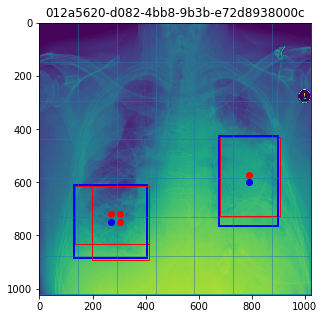

center: 0.9315068493150684 0.9315068493150684
center: 0.22945205479452055 0.9315068493150684
center: 0.910958904109589 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.14383561643835616
center: 0.22945205479452055 0.14383561643835616
center: 0.910958904109589 0.4280821917808219
center: 0.0684931506849315 0.4280821917808219
center: 0.910958904109589 0.0684931506849315


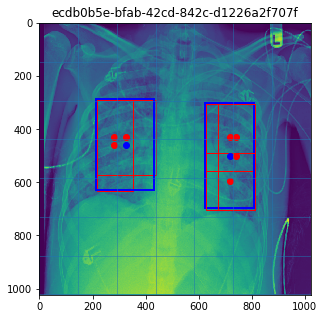

center: 0.9315068493150684 0.9315068493150684
center: 0.4657534246575342 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.7842465753424658 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.8527397260273972
center: 0.4657534246575342 0.8527397260273972
center: 0.0684931506849315 0.8527397260273972
center: 0.7842465753424658 0.0410958904109589
center: 0.0684931506849315 0.0410958904109589
center: 0.9315068493150684 0.0684931506849315
center: 0.4657534246575342 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.7842465753424658 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


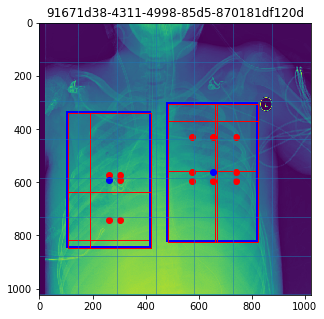

center: 0.9315068493150684 0.9315068493150684
center: 0.010273972602739725 0.9315068493150684
center: 0.985 0.4417808219178082
center: 0.010273972602739725 0.4417808219178082
center: 0.9315068493150684 0.0684931506849315
center: 0.010273972602739725 0.0684931506849315


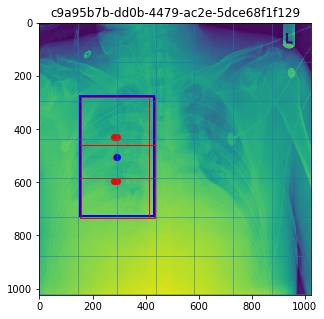

center: 0.1780821917808219 0.9315068493150684
center: 0.1780821917808219 0.21232876712328766
center: 0.1780821917808219 0.0684931506849315


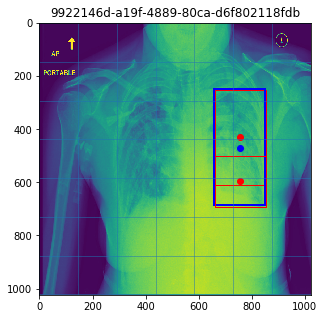

center: 0.9315068493150684 0.9315068493150684
center: 0.22602739726027396 0.9315068493150684
center: 0.9315068493150684 0.797945205479452
center: 0.22602739726027396 0.797945205479452
center: 0.9315068493150684 0.9315068493150684
center: 0.0821917808219178 0.9315068493150684
center: 0.9315068493150684 0.0684931506849315
center: 0.22602739726027396 0.0684931506849315
center: 0.9315068493150684 0.1952054794520548
center: 0.0821917808219178 0.1952054794520548
center: 0.9315068493150684 0.0684931506849315
center: 0.0821917808219178 0.0684931506849315


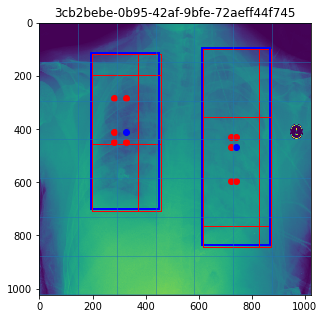

center: 0.7568493150684932 0.9315068493150684
center: 0.7568493150684932 0.9486301369863014
center: 0.0684931506849315 0.9486301369863014
center: 0.9315068493150684 0.9315068493150684
center: 0.11301369863013698 0.9315068493150684
center: 0.7568493150684932 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.9315068493150684 0.3698630136986301
center: 0.11301369863013698 0.3698630136986301
center: 0.9315068493150684 0.0684931506849315
center: 0.11301369863013698 0.0684931506849315


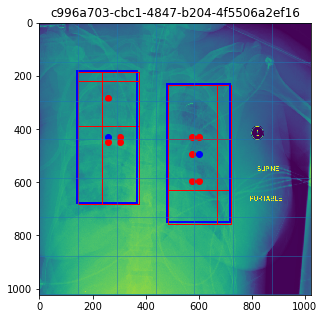

center: 0.3424657534246575 0.9315068493150684
center: 0.9315068493150684 0.7568493150684932
center: 0.3424657534246575 0.7568493150684932
center: 0.547945205479452 0.8732876712328768
center: 0.9315068493150684 0.0684931506849315
center: 0.3424657534246575 0.0684931506849315
center: 0.547945205479452 0.0684931506849315


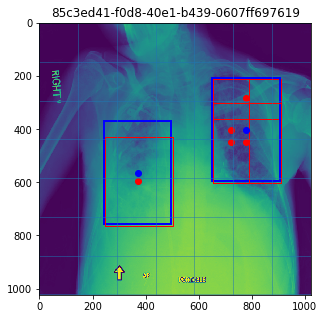

center: 0.9452054794520548 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.9315068493150684 0.9315068493150684
center: 0.3938356164383562 0.9315068493150684
center: 0.9452054794520548 0.3595890410958904
center: 0.0684931506849315 0.3595890410958904
center: 0.9315068493150684 0.6986301369863014
center: 0.3938356164383562 0.6986301369863014
center: 0.9452054794520548 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.9315068493150684 0.0684931506849315
center: 0.3938356164383562 0.0684931506849315


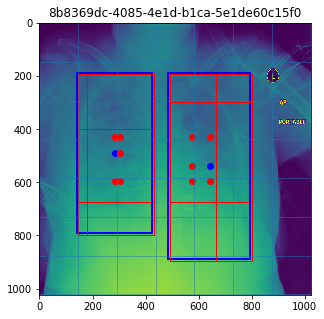

center: 0.8424657534246576 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.5342465753424658 0.9315068493150684
center: 0.8424657534246576 0.6917808219178082
center: 0.0684931506849315 0.6917808219178082
center: 0.5342465753424658 0.2602739726027397
center: 0.8424657534246576 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


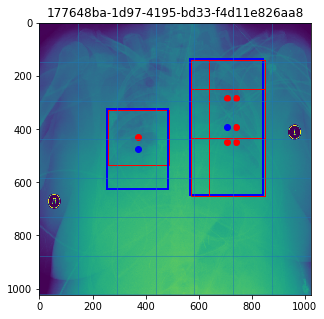

center: 0.6061643835616438 0.9315068493150684
center: 0.9315068493150684 0.9315068493150684
center: 0.4863013698630137 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6061643835616438 0.4178082191780822
center: 0.9315068493150684 0.910958904109589
center: 0.4863013698630137 0.910958904109589
center: 0.0684931506849315 0.910958904109589
center: 0.6061643835616438 0.0684931506849315
center: 0.9315068493150684 0.0684931506849315
center: 0.4863013698630137 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


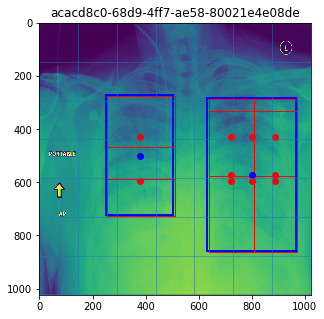

center: 0.6404109589041096 0.9315068493150684
center: 0.7431506849315068 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6404109589041096 0.7876712328767124
center: 0.7431506849315068 0.684931506849315
center: 0.0684931506849315 0.684931506849315
center: 0.6404109589041096 0.0684931506849315
center: 0.7431506849315068 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


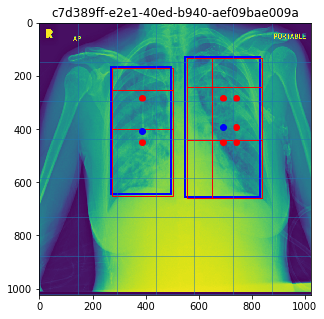

center: 0.5787671232876712 0.9315068493150684
center: 0.523972602739726 0.9315068493150684
center: 0.5787671232876712 0.8938356164383562
center: 0.0684931506849315 0.8938356164383562
center: 0.523972602739726 0.678082191780822
center: 0.5787671232876712 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315
center: 0.523972602739726 0.0684931506849315


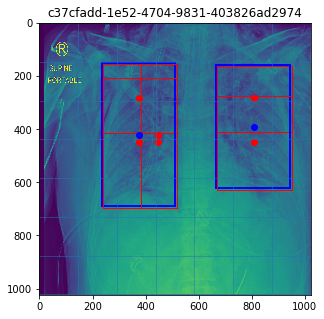

center: 0.6404109589041096 0.9315068493150684
center: 0.7431506849315068 0.9315068493150684
center: 0.0684931506849315 0.9315068493150684
center: 0.6404109589041096 0.7876712328767124
center: 0.7431506849315068 0.684931506849315
center: 0.0684931506849315 0.684931506849315
center: 0.6404109589041096 0.0684931506849315
center: 0.7431506849315068 0.0684931506849315
center: 0.0684931506849315 0.0684931506849315


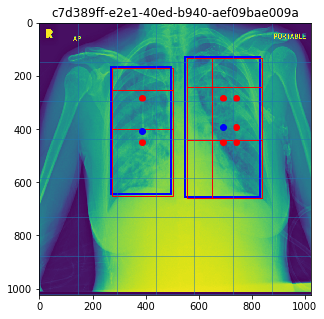

center: 0.9315068493150684 0.9417808219178082
center: 0.13013698630136986 0.9417808219178082
center: 0.9006849315068494 0.2671232876712329
center: 0.0684931506849315 0.2671232876712329
center: 0.9315068493150684 0.0684931506849315
center: 0.13013698630136986 0.0684931506849315


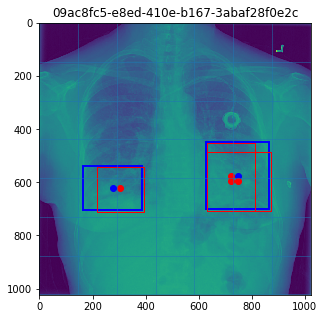

In [11]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(jittered_images, size=10, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples =  list(samples) + ["acacd8c0-68d9-4ff7-ae58-80021e4e08de","c7d389ff-e2e1-40ed-b940-aef09bae009a", "c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a", "09ac8fc5-e8ed-410e-b167-3abaf28f0e2c"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    # if the image is positive
    if np.max(labels[...,0]) > 0.5:
        fig,ax = plt.subplots(1, figsize=(5,5))
        plt.imshow(img)
        
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if labels[i,j,0] > 0.5:
                    x, y, w, h = labels[i,j,1:]
                    w,h = w*1024, h*1024
                    center_x = unnorm(x, j, CELL_WIDTH)
                    center_y = unnorm(y, i, CELL_WIDTH)


                    print("center:", x, y)
                    x = center_x - (w / 2)
                    y = center_y - (h / 2)

                    if labels[i,j,0] == 1:
                        rect_1 = patches.Rectangle((x-2,y-2),w,h,linewidth=2,edgecolor='b',facecolor='none')
                        plt.plot(center_x, center_y, marker="o", color="b")
                    else:
                        rect_1 = patches.Rectangle((x+2,y+2),w+2,h+2,linewidth=1,edgecolor='r',facecolor='none')
                        plt.plot(center_x, center_y, marker="o", color="r")

                    ax.add_patch(rect_1)

        for item in coords:
            plt.axvline(item, linewidth=0.5)
            plt.axhline(item, linewidth=0.5)
    
        plt.title(filename)
        plt.show()

## Reference

center: 0.470703125 0.650390625
center: 0.150390625 0.52734375
center: 0.470703125 0.0390625


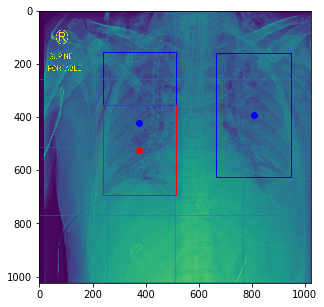

center: 0.505859375 0.58984375
center: 0.705078125 0.53125


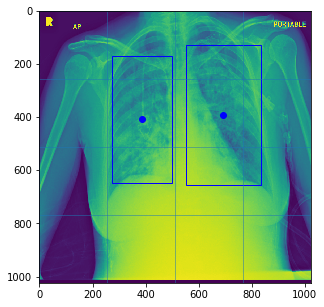

In [52]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples = ["c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 0.5:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                center_x = unnorm(x, j, CELL_WIDTH)
                center_y = unnorm(y, i, CELL_WIDTH)
                
                
                print("center:", x, y)
                x = center_x - (w / 2)
                y = center_y - (h / 2)
                
                if labels[i,j,0] == 1:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="b")
                else:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="r")
                    
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
      
    plt.show()

Confs: [[0.   0.   0.   0.  ]
 [0.   1.   0.   1.  ]
 [0.   0.99 0.   0.  ]
 [0.   0.   0.   0.  ]]
center: 0.849609375 0.52734375
center: 0.529296875 0.650390625
center: 0.529296875 0.0390625


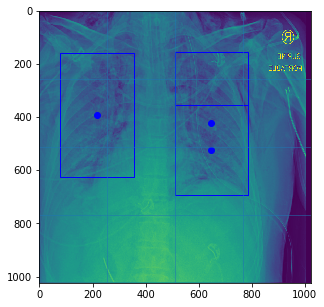

Confs: [[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
center: 0.294921875 0.53125
center: 0.494140625 0.58984375


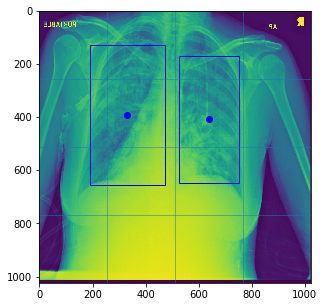

In [65]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

# samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]
samples = ["c37cfadd-1e52-4704-9831-403826ad2974", "c7d389ff-e2e1-40ed-b940-aef09bae009a"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    
    # flip the image
    img = np.fliplr(img)
    
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    print("Confs:", labels[...,0])
    confs = np.round(labels[:,:,0])
    boxes = labels[:,:,1:]
    
    # flip the labels
    mask = (confs != 0.0)
            
    # flip
    boxes[mask, 0] = (1 - boxes[mask,0])

    # flip our boxes lr on axis 0
    boxes = np.flip(boxes, axis=1)         

    # flip the confidences lr as well
    confs = np.flip(confs, axis=1)
    
    labels = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 0.5:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                center_x = unnorm(x, j, CELL_WIDTH)
                center_y = unnorm(y, i, CELL_WIDTH)
                
                
                print("center:", x, y)
                x = center_x - (w / 2)
                y = center_y - (h / 2)
                
                if labels[i,j,0] == 1:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="b")
                else:
                    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                    plt.plot(center_x, center_y, marker="o", color="r")
                    
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
      
    plt.show()